In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
from keras import layers as L
from keras import Input
from keras import Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


In [6]:
df = pd.read_csv("../data/people_data.csv")
print(df.head())
df = df.drop("img_name",axis=1)

   age  ethnicity  gender                        img_name  \
0    1          2       0  20161219203650636.jpg.chip.jpg   
1    1          2       0  20161219222752047.jpg.chip.jpg   
2    1          2       0  20161219222832191.jpg.chip.jpg   
3    1          2       0  20161220144911423.jpg.chip.jpg   
4    1          2       0  20161220144914327.jpg.chip.jpg   

                                              pixels  
0  129 128 128 126 127 130 133 135 139 142 145 14...  
1  164 74 111 168 169 171 175 182 184 188 193 199...  
2  67 70 71 70 69 67 70 79 90 103 116 132 145 155...  
3  193 197 198 200 199 200 202 203 204 205 208 21...  
4  202 205 209 210 209 209 210 211 212 214 218 21...  


In [7]:
df["pixels"] = df["pixels"].apply(lambda x: np.array(x.split(),dtype="float32"))
df["pixels"] = df["pixels"] / 255

In [8]:
if isinstance(df['pixels'].iloc[0], str):
    df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(), dtype='float32').reshape(48, 48, 1))
else:
    df['pixels'] = df['pixels'].apply(lambda x: x.reshape(48, 48, 1))

age = df['age'].values
gender = df['gender'].values  # Ensure binary (0 or 1)
ethnicity = to_categorical(df['ethnicity'].values, num_classes=5)

x_train, x_test, age_train, age_test, gender_train, gender_test, ethnicity_train, ethnicity_test = train_test_split(
    np.stack(df['pixels'].values),
    age,
    gender,
    ethnicity,
    test_size=0.2,
    random_state=42
)

# Reshape age and gender labels to (num_samples, 1)
age_train = age_train.reshape(-1, 1)
age_test = age_test.reshape(-1, 1)
gender_train = gender_train.reshape(-1, 1)
gender_test = gender_test.reshape(-1, 1)

input_img = Input(shape=(48, 48, 1))

In [9]:
# x_train = np.zeros(shape=(23705,2304))

# for indexing in range(len(df["pixels"])):
#     x_train[indexing] = df["pixels"][indexing]

In [10]:
# x_train = x_train.reshape(-1,48,48,1)

In [11]:
# x = x_train
# y = df.iloc[:, :-1].values

In [12]:
# x_train,x_test,y_train,y_test = train_test_split(x, y, train_size=0.8, random_state=35, shuffle=True)

In [13]:
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
    )

# checkpoint_model = tf.keras.callbacks.ModelCheckpoint(
#     monitor="val_accuracy",
#     save_best_only=True,
#     save_weights_only=False,
#     filepath="./.keras"
#     )

In [14]:
COMPILE_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
COMPILE_LOSS = "msle"
COMPILE_METRICS = ["accuracy"]
INPUT_SHAPE = (x_train.shape[1],x_train.shape[2],x_train.shape[3])
OUTPUT_CLASS = 3

In [15]:
# model = tf.keras.Sequential()

# model.add(L.Input(shape=INPUT_SHAPE))
# model.add(L.Conv2D(32, (3, 3), activation="relu"))
# model.add(L.BatchNormalization())
# model.add(L.MaxPooling2D((2, 2)))

# model.add(L.Conv2D(64,(3,3),activation="relu"))
# model.add(L.Dropout(0.3))
# model.add(L.MaxPooling2D((2,2)))
# model.add(L.BatchNormalization())

# model.add(L.Conv2D(128,(3,3),activation="relu"))
# model.add(L.Dropout(0.3))
# model.add(L.MaxPooling2D((2,2)))
# model.add(L.BatchNormalization())


# model.add(L.Flatten())
# model.add(L.Dense(128,activation="relu"))
# model.add(L.BatchNormalization())
# model.add(L.Dropout(0.5))
# model.add(L.Dense(64,activation="relu"))
# model.add(L.BatchNormalization())
# model.add(L.Dropout(0.5))
# model.add(L.Dense(OUTPUT_CLASS,activation="softmax"))

In [19]:

x = L.Conv2D(32, (3, 3), activation='relu')(input_img)
x = L.MaxPooling2D(pool_size=(2, 2))(x)
x = L.Conv2D(64, (3, 3), activation='relu')(x)
x = L.MaxPooling2D(pool_size=(2, 2))(x)
x = L.Conv2D(128, (3, 3), activation='relu')(x)
x = L.Flatten()(x)
x = L.Dense(256, activation='relu')(x)
x = L.Dropout(0.5)(x)

# Output layers
age_output = L.Dense(1, name='age_output')(x)
gender_output = L.Dense(1, activation='sigmoid', name='gender_output')(x)
ethnicity_output = L.Dense(5, activation='softmax', name='ethnicity_output')(x)

# Define the model
model = Model(inputs=input_img, outputs=[age_output, gender_output, ethnicity_output])


# model.compile(optimizer=COMPILE_OPTIMIZER,loss=COMPILE_LOSS,metrics=COMPILE_METRICS)

# Compile the model with appropriate loss functions and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={
        'age_output': 'mse',
        'gender_output': 'binary_crossentropy',
        'ethnicity_output': 'categorical_crossentropy'
    },
    metrics={
        'age_output': 'mae',
        'gender_output': 'accuracy',  # Accuracy
        'ethnicity_output': 'accuracy'  # Accuracy
    }
)

In [21]:
# path = '../models/combined_model.h5'
path = '../models/test_model.h5' ### Test

# model_history = model.fit(
#     x_train, y_train,
#     validation_data=(
#         x_test, 
#         y_test),
#     callbacks=[early_stopper], # checkpoint_model
#     batch_size=12,
#     epochs=4
#     )

# model.save(path)


### TEST
model_history = model.fit(
    x_train,
    {
        'age_output': age_train,
        'gender_output': gender_train,
        'ethnicity_output': ethnicity_train
    },
    validation_data=(
        x_test,
        {
            'age_output': age_test,
            'gender_output': gender_test,
            'ethnicity_output': ethnicity_test
        }
    ),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopper]
)

model.save(path)

Epoch 1/5


c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\keras\src\losses\losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 5), output.shape=(None, 1)

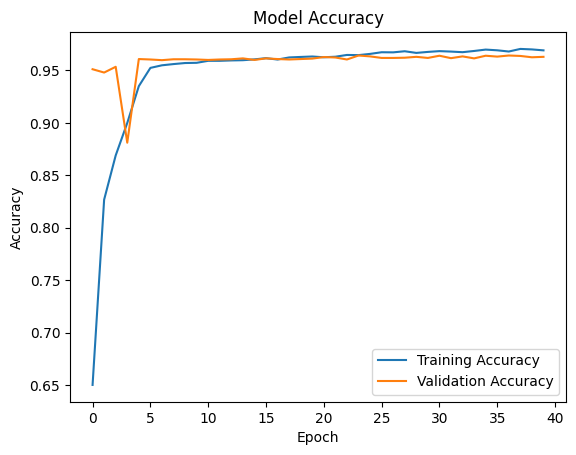

In [143]:
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [144]:
train_acc = model_history.history['accuracy'][-1]
val_acc = model_history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

Final Training Accuracy: 96.90%
Final Validation Accuracy: 96.29%
